# Imports

In [1]:
# Logging and warnings
import logging

# File R/W
import os

# Additional Inbuilt Utilities
import itertools
import functools

# Regex
import re

# Array
import numpy as np

# Table
import pandas as pd

# Advanced Computations
import scipy as sc

# Statistics
import statsmodels.api as sm
import statsmodels.stats as st

# Neurophysiological Data Analysis
import mne
import mne_nirs # esp. for fNIRS

# Neuroimaging Statistical Tools
import nilearn
import nilearn.plotting

# Plotting
import matplotlib.pyplot as plt

# Vistual Display
from pyvirtualdisplay import Display

In [2]:
# Autoreload Custom Modules
%load_ext autoreload
%autoreload 1

# Custom Class
%aimport nirs
NIRS = nirs.NIRS

# Custom Settings
%aimport constants

# Custom Functions
%aimport utils

# Modified MBLL
%aimport mbll

## Config

In [3]:
# Set logging level for custom modules
logging.getLogger().setLevel(logging.INFO)

In [4]:
# Set logging level for MNE
mne.set_log_level('WARNING')

In [5]:
# Set plotting backend for MNE
mne.viz.set_browser_backend('matplotlib') # qt, matplotlib
mne.viz.set_3d_backend('notebook') # pyvistaqt, notebook

# MAIN

##### `Pre-Processing`

In [6]:
# Instantiate NIRS() and read data
nirs = NIRS(project='Working-Memory') # Working-Memory # Multi-object Tracking
nirs.read(1, 1, 1, augment=False, transform=False, correction_factor=0.779);

In [7]:
# Pre-process the data using the default pipeline.
# Output is a dictionary of intermediate mne.Raw instances.
# Stages: CW     (raw signal)
#         CWx    (backlight removed raw signal)
#         OD     (optical density)
#         TDDR   (motion artifact removal)
#         AP     (autopick channels)
#         SSR    (short-channel regression)
#         HB     (chromophore/haemoglobin)
#         LS     (pick long channels, after saving short channels)
#         FL     (bandpass filtering)
#         NCE    (negative correlation improvement)
savepoints = nirs.default_pipeline(remove_backlight=True,
                                   tddr=True,
                                   scalp_coupling_index=True,
                                   autopick_channels=True,
                                   short_channel_regression=True,
                                   bandpass=True,
                                   negative_correlation_enhancement=False,
                                   threshold_heart_rate=0.5,
                                   show_failed=False,
                                   l_trans_bandwidth=0.007,
                                   h_trans_bandwidth=0.007)

/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:608: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  return func(self.raw, *args, **kwargs)


In [8]:
nirs.get_epochs(tmin=-(nirs.DUR['wait']),
                tmax=(nirs.DUR['motion'] + nirs.DUR['probe'] + nirs.DUR['feedb']),
                baseline=(-0.1, 0));

# Drop epochs where response was not correct
# nirs.epochs.drop(nirs.mat['id_correct'] != 1);

nirs.block_average();

##### `GLM Analysis`

In [9]:
# raw_intensity = savepoints['CW']
raw_haemo = nirs.raw.copy().pick(nirs.good_ch_names)

In [10]:
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo,
                                                                            hrf_model= 'spm', # 'spm + derivative + dispersion',
                                                                            drift_model=None, # 'cosine', 'polynomial'
                                                                            # drift_order=3,
                                                                            # high_pass=1/2/(nirs.DUR['trial']),
                                                                            stim_dur=nirs.DUR['motion'])

# design_matrix['mean_ss_hbo'] = np.mean(nirs.raw_ss.copy().pick('hbo').get_data(), axis=0)
# design_matrix['mean_ss_hbr'] = np.mean(nirs.raw_ss.copy().pick('hbr').get_data(), axis=0)

In [11]:
glm_est = mne_nirs.statistics.run_glm(raw_haemo, design_matrix)
glm_results = glm_est.to_dataframe()

In [12]:
glm_results_significant = glm_results[glm_results['Significant']]
glm_results_significant[glm_results_significant['Condition'].isin(nirs.cases)]

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
0,LOW,2.0,1.305236e-13,0.003235,2.499395e-07,-17.538039,-4.383449e-06,33,34,hbo,True,S33_D34 hbo
2,LOW,2.0,6.898445e-14,0.001221,1.817046e-07,-28.594033,-5.195668e-06,33,34,hbr,True,S33_D34 hbr
4,LOW,2.0,2.517737e-14,0.001094,1.097730e-07,-30.202249,-3.315392e-06,33,40,hbo,True,S33_D40 hbo
6,LOW,2.0,9.167531e-15,0.004697,6.623943e-08,-14.539120,-9.630629e-07,33,40,hbr,True,S33_D40 hbr
8,LOW,2.0,1.617086e-14,0.001754,8.797452e-08,-23.846162,-2.097855e-06,33,43,hbo,True,S33_D43 hbo
12,LOW,2.0,2.262010e-14,0.002631,1.040489e-07,-19.457584,-2.024541e-06,33,44,hbo,True,S33_D44 hbo
16,LOW,2.0,1.806847e-13,0.002348,2.940703e-07,-20.599809,-6.057791e-06,34,33,hbo,True,S34_D33 hbo
18,LOW,2.0,8.709833e-14,0.002895,2.041716e-07,18.543865,3.786130e-06,34,33,hbr,True,S34_D33 hbr
22,LOW,2.0,1.929946e-13,0.010198,3.039226e-07,-9.826523,-2.986502e-06,34,39,hbr,True,S34_D39 hbr
24,LOW,2.0,6.821670e-14,0.011420,1.806907e-07,-9.277220,-1.676307e-06,34,41,hbo,True,S34_D41 hbo


In [13]:
significant_channels = list(glm_results_significant[
    glm_results_significant['Condition'].isin(list(set(nirs.cases)))
    & (((glm_results_significant['Chroma'] == 'hbo') & (glm_results_significant['theta'] > 0))
     | ((glm_results_significant['Chroma'] == 'hbr') & (glm_results_significant['theta'] < 0)))
]['ch_name'].unique())

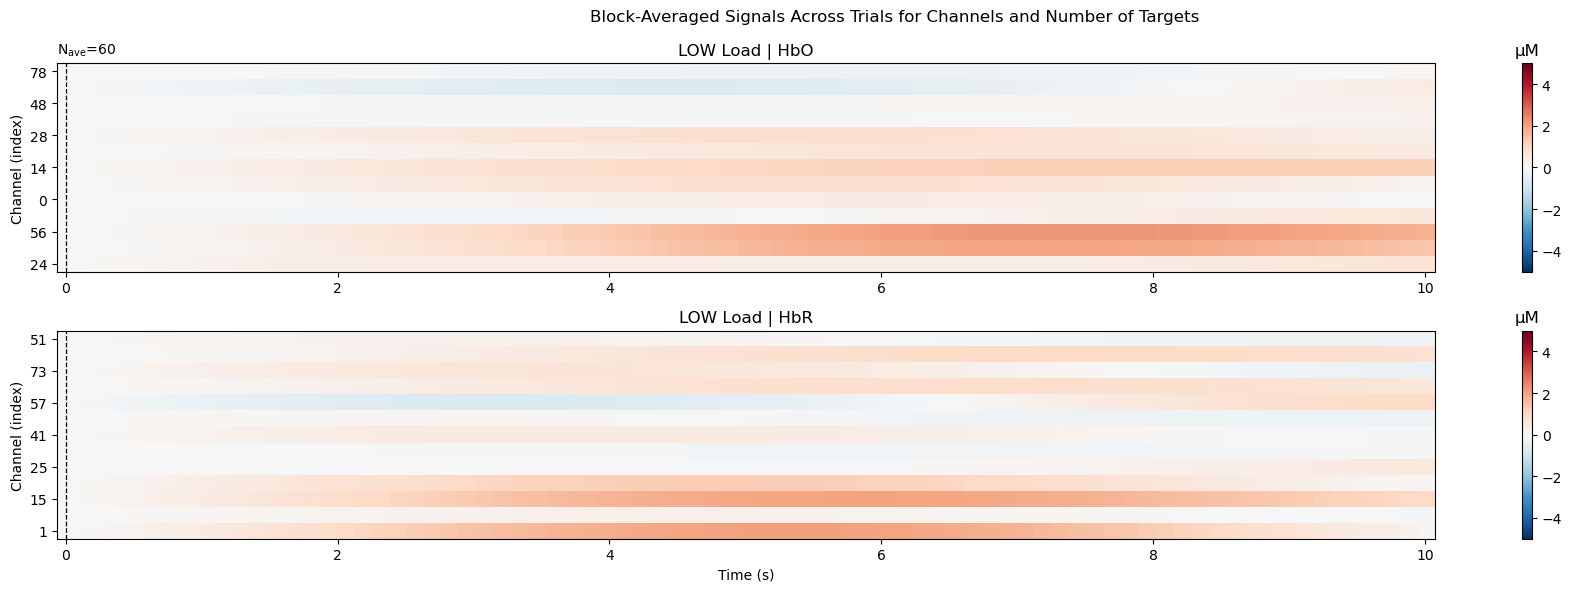

In [14]:
nirs.plot_average_heatmap(picks=significant_channels + utils.find_ch_pairs(nirs.raw.ch_names, significant_channels),
                          clim={'hbo': [-5, 5], 'hbr': [-5, 5]}).tight_layout()

##### `Contrast Analysis`

> Compute and visualize constrasts between cases

##### `GLM Analysis (combined)`

In [15]:
nirs_1 = NIRS(project='Multi-object Tracking').read(1, 2, 2, augment=True, transform=True, correction_factor=0.779)
nirs_2 = NIRS(project='Multi-object Tracking').read(1, 2, 3, augment=True, transform=True, correction_factor=0.779)

In [16]:
savepoints_1 = nirs_1.default_pipeline(remove_backlight=True, tddr=True, autopick_channels=False, short_channel_regression=True, bandpass=True, negative_correlation_enhancement=False, l_trans_bandwidth=0.007, h_trans_bandwidth=0.007)
savepoints_2 = nirs_2.default_pipeline(remove_backlight=True, tddr=True, autopick_channels=False, short_channel_regression=True, bandpass=True, negative_correlation_enhancement=False, l_trans_bandwidth=0.007, h_trans_bandwidth=0.007)

/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:608: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  return func(self.raw, *args, **kwargs)
/home/pulkitgoyal56/fNIRS-attentional-load/nirs.py:608: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  return func(self.raw, *args, **kwargs)


In [17]:
nirs_1.get_epochs(tmin=-(nirs_1.DUR['wait']), tmax=(nirs_1.DUR['motion'] + nirs_1.DUR['probe'] + nirs_1.DUR['feedb']), baseline=(-0.1, 0))
nirs_2.get_epochs(tmin=-(nirs_1.DUR['wait']), tmax=(nirs_2.DUR['motion'] + nirs_2.DUR['probe'] + nirs_2.DUR['feedb']), baseline=(-0.1, 0));

# Drop epochs where response was not correct
# nirs.epochs.drop(nirs.mat['id_correct'] != 1);

nirs_1.block_average();
nirs_2.block_average();

In [18]:
raw_haemo_1 = nirs_1.raw.copy()
raw_haemo_2 = nirs_2.raw.copy()

In [19]:
raw_haemo_1.info['bads'] = raw_haemo_2.info['bads'] = list(set(raw_haemo_1.info['bads'] + raw_haemo_1.info['bads']))
raw_haemo_combined = mne.concatenate_raws([raw_haemo_1, raw_haemo_2])

In [20]:
design_matrix_combined = mne_nirs.experimental_design.make_first_level_design_matrix(raw_haemo_combined,
                                                                                     hrf_model= 'spm', # 'spm + derivative + dispersion',
                                                                                     drift_model=None, # 'cosine', 'polynomial'
                                                                                     # drift_order=3,
                                                                                     # high_pass=1/2/(nirs.DUR['trial']),
                                                                                     stim_dur=nirs.DUR['motion'])

# design_matrix['mean_ss_hbo'] = np.r_[np.mean(nirs_1.raw_ss.copy().pick('hbo').get_data(), axis=0), np.mean(nirs_2.raw_ss.copy().pick('hbo').get_data(), axis=0)]
# design_matrix['mean_ss_hbr'] = np.r_[np.mean(nirs_1.raw_ss.copy().pick('hbr').get_data(), axis=0), np.mean(nirs_2.raw_ss.copy().pick('hbr').get_data(), axis=0)]

# design_matrix_combined.drop(columns=['BAD boundary'], inplace=True)
# design_matrix_combined.drop(columns=['EDGE boundary'], inplace=True);

/home/pulkitgoyal56/miniconda3/envs/fnirs/lib/python3.10/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


In [21]:
glm_est_combined = mne_nirs.statistics.run_glm(raw_haemo_combined, design_matrix_combined)
glm_results_combined = glm_est_combined.to_dataframe()

In [22]:
glm_results_combined_significant = glm_results_combined[glm_results_combined['Significant']]
glm_results_combined_significant[glm_results_combined_significant['Condition'].isin(nirs.cases)]

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name


In [23]:
significant_channels_combined = list(glm_results_combined_significant[
    glm_results_combined_significant['Condition'].isin(list(set(nirs.cases)))
    & (((glm_results_combined_significant['Chroma'] == 'hbo') & (glm_results_combined_significant['theta'] > 0))
     | ((glm_results_combined_significant['Chroma'] == 'hbr') & (glm_results_combined_significant['theta'] < 0)))
]['ch_name'].unique())

##### `Plotting for GLM Analysis`

##### `Clustering`

> Relevant features  
>> For intervals of 1s in the epochs.  
>> - Area under the curve  
>> - Average slope  
>> - Maximum amplitude